In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
import geopy.distance
from sklearn.pipeline import Pipeline
from datetime import timedelta 

In [2]:
df = pd.read_csv('nyc bus data.csv')
df = df.drop_duplicates()
# = df.dropna()
df.head()

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Unnamed: 17
0,6/1/2017 0:03,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76,6/1/2017 0:03,24:06:14,NaN
1,6/1/2017 0:03,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,40.590802,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62,6/1/2017 0:03,23:58:02,NaN
2,6/1/2017 0:03,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,40.886010,-73.912647,HENRY HUDSON PKY E/W 235 ST,at stop,5,6/1/2017 0:03,24:00:53,NaN
3,6/1/2017 0:03,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,40.668002,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267,6/1/2017 0:04,24:03:00,NaN
4,6/1/2017 0:03,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,40.868134,-73.893032,GRAND CONCOURSE/E 196 ST,at stop,11,6/1/2017 0:03,23:59:38,NaN


In [3]:
df.shape

(1048575, 18)

In [4]:
#checking for column types and missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
RecordedAtTime               1048575 non-null object
DirectionRef                 1048575 non-null int64
PublishedLineName            1048575 non-null object
OriginName                   1040112 non-null object
OriginLat                    1040112 non-null float64
OriginLong                   1040112 non-null float64
DestinationName              1048575 non-null object
DestinationLat               1047329 non-null float64
DestinationLong              1047329 non-null float64
VehicleRef                   1048575 non-null object
VehicleLocation.Latitude     1048575 non-null float64
VehicleLocation.Longitude    1048575 non-null float64
NextStopPointName            1047439 non-null object
ArrivalProximityText         1047439 non-null object
DistanceFromStop             1047439 non-null object
ExpectedArrivalTime          931342 non-null object
ScheduledArrivalTime         102290

In [5]:
#filling in missing data 
df['OriginName'].ffill(axis=0, inplace=True)
df['OriginLat'].ffill(axis=0, inplace=True)
df['OriginLong'].ffill(axis=0, inplace=True)
df['DestinationLat'].ffill(axis=0, inplace=True)
df['DestinationLong'].ffill(axis=0, inplace=True)
df['DistanceFromStop'].ffill(axis=0, inplace=True)
df['ArrivalProximityText'].ffill(axis=0, inplace=True)
df['NextStopPointName'].ffill(axis=0, inplace=True)
df['ExpectedArrivalTime'].ffill(axis=0, inplace=True)
df['ScheduledArrivalTime'].ffill(axis=0, inplace=True)


In [6]:
#splitting 'ExpectedArrivalTime' column
expected_split = df['ExpectedArrivalTime'].str.split(expand=True)
print(expected_split.head())

          0     1
0  6/1/2017  0:03
1  6/1/2017  0:03
2  6/1/2017  0:03
3  6/1/2017  0:04
4  6/1/2017  0:03


In [7]:
#creating new feature; the 'expected_date' column
df['expected_date'] = expected_split[0]

In [8]:
#formatting the 'ScheduledArrivalTime'
df['ScheduledArrivalTime'] = df['ScheduledArrivalTime'].apply(lambda x: x[0:2].replace('24', '00')) + df['ScheduledArrivalTime'].apply(lambda x: x[2:])

In [9]:
#examining the 'ScheduledArrivalTime' column
df['ScheduledArrivalTime'].head()

0    00:06:14
1    23:58:02
2    00:00:53
3    00:03:00
4    23:59:38
Name: ScheduledArrivalTime, dtype: object

In [10]:
#creating new feature'Scheduled_datetime' column
df['Scheduled_datetime'] = df['expected_date'] + ' ' + df['ScheduledArrivalTime']

In [11]:
#examining 'Scheduled_datetime' column
df['Scheduled_datetime'].head()

0    6/1/2017 00:06:14
1    6/1/2017 23:58:02
2    6/1/2017 00:00:53
3    6/1/2017 00:03:00
4    6/1/2017 23:59:38
Name: Scheduled_datetime, dtype: object

In [12]:
#converting 'Scheduled_datetime' to datetime object
df['Scheduled_datetime'] = pd.to_datetime(df['Scheduled_datetime'], errors='coerce')

In [13]:
#converting 'Expected_arrival' column to datetime object
df['Expected_datetime'] = pd.to_datetime(df['ExpectedArrivalTime'], errors='coerce')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
RecordedAtTime               1048575 non-null object
DirectionRef                 1048575 non-null int64
PublishedLineName            1048575 non-null object
OriginName                   1048575 non-null object
OriginLat                    1048575 non-null float64
OriginLong                   1048575 non-null float64
DestinationName              1048575 non-null object
DestinationLat               1048575 non-null float64
DestinationLong              1048575 non-null float64
VehicleRef                   1048575 non-null object
VehicleLocation.Latitude     1048575 non-null float64
VehicleLocation.Longitude    1048575 non-null float64
NextStopPointName            1048575 non-null object
ArrivalProximityText         1048575 non-null object
DistanceFromStop             1048575 non-null object
ExpectedArrivalTime          1048575 non-null object
ScheduledArrivalTime         10485

In [15]:
#filling in missing data
df['Scheduled_datetime'].ffill(axis=0, inplace=True)
df['Expected_datetime'].ffill(axis=0, inplace=True)


In [16]:
df.isnull().sum().sum()

1048516

The above null values are in the "Unnamed" column, which I will drop later

In [17]:
#fixing the date value, by subtracting one day, for those datetime entries where the hour is near midnight.
df['Scheduled_datetime'] = df['Scheduled_datetime'].apply(lambda x: x - timedelta(days=1) if str(x)[11:13] == '23' else x)

In [18]:
#create new feature to record the difference between each bus's scheduled arrival time and expected arrival time.
df['delay'] = df['Expected_datetime'] - df['Scheduled_datetime']

In [19]:
df.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Unnamed: 17,expected_date,Scheduled_datetime,Expected_datetime,delay
0,6/1/2017 0:03,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,...,FOSTER AV/E 18 ST,approaching,76,6/1/2017 0:03,00:06:14,NaN,6/1/2017,2017-06-01 00:06:14,2017-06-01 00:03:00,-1 days +23:56:46
1,6/1/2017 0:03,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,...,MERRYMOUNT ST/TRAVIS AV,approaching,62,6/1/2017 0:03,23:58:02,NaN,6/1/2017,2017-05-31 23:58:02,2017-06-01 00:03:00,00:04:58
2,6/1/2017 0:03,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,...,HENRY HUDSON PKY E/W 235 ST,at stop,5,6/1/2017 0:03,00:00:53,NaN,6/1/2017,2017-06-01 00:00:53,2017-06-01 00:03:00,00:02:07
3,6/1/2017 0:03,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,...,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267,6/1/2017 0:04,00:03:00,NaN,6/1/2017,2017-06-01 00:03:00,2017-06-01 00:04:00,00:01:00
4,6/1/2017 0:03,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,...,GRAND CONCOURSE/E 196 ST,at stop,11,6/1/2017 0:03,23:59:38,NaN,6/1/2017,2017-05-31 23:59:38,2017-06-01 00:03:00,00:03:22


In [20]:
#creating new feature called 'Scheduled_HourOfDay', to reflect relationship of the time of day and whether or not a bus is on time.
#Certain bus routes may be effected by non controllable conditions such as traffic, which is more of a factor during rush hour
#and accounting for the hour of day may help the model capture that relationship. 
df['Scheduled_HourOfDay'] = df['Scheduled_datetime'].dt.hour

In [21]:
#creating a new feature "delay_second" to equate 'delay' column in seconds
df['delay_second'] = df['delay'].dt.seconds

In [22]:
#creating new feature 'delay_minute' to convert the delay_second to minutes
df['delay_minute'] = df['delay_second'] / 60

In [23]:
df.delay.value_counts().head(10)

00:01:00             21215
00:00:00             20973
00:02:00             19748
-1 days +23:59:00    18994
00:03:00             17457
00:04:00             15582
-1 days +23:58:00    14392
00:05:00             13712
00:06:00             12310
00:07:00             10952
Name: delay, dtype: int64

The "delay" feature in the dataset has some values that are negative in days.  To explore this further, I am going to extract the days from the "delay" column to get more insight into the data.

In [24]:
#creating new feature delay_days by extracting the day value from 'delay' column.  
df['delay_days'] = df['delay'].dt.days

In [25]:
df.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,ScheduledArrivalTime,Unnamed: 17,expected_date,Scheduled_datetime,Expected_datetime,delay,Scheduled_HourOfDay,delay_second,delay_minute,delay_days
0,6/1/2017 0:03,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,...,00:06:14,NaN,6/1/2017,2017-06-01 00:06:14,2017-06-01 00:03:00,-1 days +23:56:46,0,86206,1436.766667,-1
1,6/1/2017 0:03,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,...,23:58:02,NaN,6/1/2017,2017-05-31 23:58:02,2017-06-01 00:03:00,00:04:58,23,298,4.966667,0
2,6/1/2017 0:03,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,...,00:00:53,NaN,6/1/2017,2017-06-01 00:00:53,2017-06-01 00:03:00,00:02:07,0,127,2.116667,0
3,6/1/2017 0:03,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,...,00:03:00,NaN,6/1/2017,2017-06-01 00:03:00,2017-06-01 00:04:00,00:01:00,0,60,1.000000,0
4,6/1/2017 0:03,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,...,23:59:38,NaN,6/1/2017,2017-05-31 23:59:38,2017-06-01 00:03:00,00:03:22,23,202,3.366667,0


# Data Exploration:

Next I'm going to explore the data by subsetting the data by the values of the "delay_days" column.  

In [26]:
#getting value_counts for all values for the delay_days column.
df.delay_days.value_counts()

 0        764562
-1        271111
 1         12899
-10075         2
-17377         1
Name: delay_days, dtype: int64

In [27]:
#subsetting the data for those observations where delay_days equals 1
df_DelayDayOne = df[df['delay_days'] == 1]

In [28]:
df_DelayDayOne.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,ScheduledArrivalTime,Unnamed: 17,expected_date,Scheduled_datetime,Expected_datetime,delay,Scheduled_HourOfDay,delay_second,delay_minute,delay_days
243349,6/1/2017 22:54,1,X10,E 57 ST/3 AV,40.760429,-73.967674,PT RICHMOND via NARROWS RD via GANNON AV,40.633698,-74.129776,NYCT_2664,...,23:02:56,NaN,6/1/2017,2017-05-31 23:02:56,2017-06-01 23:08:00,1 days 00:05:04,23,304,5.066667,1
243883,6/1/2017 23:04,0,B61,PROSPECT PK W/18 ST,40.657639,-73.982887,DOWNTOWN BKLYN FULTON MALL via RED HOOK,40.690514,-73.987724,NYCT_774,...,23:00:35,NaN,6/1/2017,2017-05-31 23:00:35,2017-06-01 23:05:00,1 days 00:04:25,23,265,4.416667,1
243885,6/1/2017 23:04,0,M57,W 72 ST/BROADWAY,40.779034,-73.982414,EAST SIDE YORK - 60 ST XTOWN,40.759518,-73.959892,NYCT_3820,...,23:02:22,NaN,6/1/2017,2017-05-31 23:02:22,2017-06-01 23:04:00,1 days 00:01:38,23,98,1.633333,1
243888,6/1/2017 23:04,0,Q44-SBS,MERRICK BL/ARCHER AV,40.704906,-73.793304,SELECT BUS BRONX ZOO via MAIN ST,40.842457,-73.877121,NYCT_5912,...,23:03:47,NaN,6/1/2017,2017-05-31 23:03:47,2017-06-01 23:06:00,1 days 00:02:13,23,133,2.216667,1
243890,6/1/2017 23:04,0,B44,KNAPP ST/SHORE PKY,40.585033,-73.931328,WILLAMSBURG BRIDGE PLZ via NOSTRAND,40.709316,-73.959587,NYCT_5045,...,23:01:44,NaN,6/1/2017,2017-05-31 23:01:44,2017-06-01 23:04:00,1 days 00:02:16,23,136,2.266667,1


#### Exploring dataframe where "delay_days" equals zero.

In [29]:
#filtering the original dataset
df_DelayDayZero = df[df['delay_days'] == 0]

In [30]:
df_DelayDayZero.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,ScheduledArrivalTime,Unnamed: 17,expected_date,Scheduled_datetime,Expected_datetime,delay,Scheduled_HourOfDay,delay_second,delay_minute,delay_days
1,6/1/2017 0:03,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,...,23:58:02,NaN,6/1/2017,2017-05-31 23:58:02,2017-06-01 00:03:00,00:04:58,23,298,4.966667,0
2,6/1/2017 0:03,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,...,00:00:53,NaN,6/1/2017,2017-06-01 00:00:53,2017-06-01 00:03:00,00:02:07,0,127,2.116667,0
3,6/1/2017 0:03,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,...,00:03:00,NaN,6/1/2017,2017-06-01 00:03:00,2017-06-01 00:04:00,00:01:00,0,60,1.000000,0
4,6/1/2017 0:03,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,...,23:59:38,NaN,6/1/2017,2017-05-31 23:59:38,2017-06-01 00:03:00,00:03:22,23,202,3.366667,0
5,6/1/2017 0:03,0,M1,4 AV/E 10 ST,40.731342,-73.990288,HARLEM 147 ST via MADISON,40.821110,-73.935898,NYCT_3831,...,00:02:35,NaN,6/1/2017,2017-06-01 00:02:35,2017-06-01 00:03:00,00:00:25,0,25,0.416667,0


In [31]:
#value counts of the dates in scheduled datetime
df_DelayDayZero.Scheduled_datetime.dt.date.value_counts()

2017-06-02    187562
2017-06-01    176890
2017-06-05    161573
2017-06-03    132538
2017-06-04    104490
2017-05-31      1509
Name: Scheduled_datetime, dtype: int64

In [32]:
#value_counts of the dates in Expected datetime
df_DelayDayZero.Expected_datetime.dt.date.value_counts()

2017-06-02    187434
2017-06-01    177178
2017-06-05    162137
2017-06-03    132419
2017-06-04    105394
Name: Expected_datetime, dtype: int64

In [33]:
df_DelayDayZero.delay.value_counts()

00:01:00    21215
00:00:00    20973
00:02:00    19748
00:03:00    17457
00:04:00    15582
00:05:00    13712
00:06:00    12310
00:07:00    10952
00:08:00     9878
00:09:00     8917
00:10:00     7993
00:11:00     7055
00:12:00     6291
00:13:00     5477
00:14:00     4953
00:15:00     4187
00:16:00     3671
00:17:00     3111
00:18:00     2872
00:19:00     2403
00:12:02     2121
00:20:00     2113
00:21:00     1884
00:06:40     1718
00:22:00     1661
00:22:12     1582
00:36:00     1567
00:23:00     1519
00:24:00     1402
00:00:52     1230
            ...  
01:04:49        1
23:55:07        1
01:03:37        1
03:13:00        1
00:55:18        1
23:25:00        1
23:55:37        1
23:30:47        1
01:09:54        1
01:14:38        1
01:21:54        1
00:54:09        1
00:57:12        1
23:52:43        1
01:34:00        1
00:47:03        1
01:45:00        1
00:53:34        1
23:55:14        1
01:11:58        1
01:20:05        1
23:32:43        1
23:54:23        1
01:10:36        1
23:45:26  

In [34]:
df_DelayDayZero.delay_minute.value_counts()

1.000000       21215
0.000000       20973
2.000000       19748
3.000000       17457
4.000000       15582
5.000000       13712
6.000000       12310
7.000000       10952
8.000000        9878
9.000000        8917
10.000000       7993
11.000000       7055
12.000000       6291
13.000000       5477
14.000000       4953
15.000000       4187
16.000000       3671
17.000000       3111
18.000000       2872
19.000000       2403
12.033333       2121
20.000000       2113
21.000000       1884
6.666667        1718
22.000000       1661
22.200000       1582
36.000000       1567
23.000000       1519
24.000000       1402
0.533333        1230
               ...  
1432.166667        1
119.566667         1
51.216667          1
1409.516667        1
1424.783333        1
63.383333          1
1436.966667        1
1434.716667        1
1432.233333        1
1433.733333        1
1432.966667        1
1432.716667        1
1432.466667        1
1430.283333        1
69.666667          1
1433.216667        1
1412.716667  

#### Exploring the dataset where "delay_days" equals -1. 

In [35]:
#filtering the original dataset for only those observations where 'delay_days' equals -1
df_DelayDay_neg1 = df[df['delay_days'] == -1]

In [36]:
df_DelayDay_neg1.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,ScheduledArrivalTime,Unnamed: 17,expected_date,Scheduled_datetime,Expected_datetime,delay,Scheduled_HourOfDay,delay_second,delay_minute,delay_days
0,6/1/2017 0:03,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,...,00:06:14,NaN,6/1/2017,2017-06-01 00:06:14,2017-06-01 00:03:00,-1 days +23:56:46,0,86206,1436.766667,-1
6,6/1/2017 0:03,0,B31,GERRITSEN AV/GERRITSEN BEACH,40.587101,-73.918503,MIDWOOD KINGS HWY STA,40.608433,-73.957100,NYCT_4611,...,00:08:00,NaN,6/1/2017,2017-06-01 00:08:00,2017-06-01 00:03:00,-1 days +23:55:00,0,86100,1435.000000,-1
11,6/1/2017 0:03,1,B1,87 ST/4 Av,40.621925,-74.028496,MANHATTAN BEACH KINGSBORO CC,40.578094,-73.940170,NYCT_7141,...,00:05:55,NaN,6/1/2017,2017-06-01 00:05:55,2017-06-01 00:03:00,-1 days +23:57:05,0,86225,1437.083333,-1
12,6/1/2017 0:03,1,B26,WYCKOFF ST/PALMETTO ST,40.699150,-73.910477,DNTWN BKLYN TILLARY ST via HALSEY,40.693939,-73.990311,NYCT_6503,...,00:05:55,NaN,6/1/2017,2017-06-01 00:05:55,2017-06-01 00:03:00,-1 days +23:57:05,0,86225,1437.083333,-1
13,6/1/2017 0:03,0,Bx39,SOUNDVIEW AV/STEPHENS AV,40.807869,-73.852715,WAKEFIELD 241 ST via WHITE PLS RD,40.903309,-73.849922,NYCT_4723,...,00:04:12,NaN,6/1/2017,2017-06-01 00:04:12,2017-06-01 00:04:00,-1 days +23:59:48,0,86388,1439.800000,-1


In [37]:
df_DelayDay_neg1.shape

(271111, 26)

In [38]:
#calculating the time difference according to minutes
df_DelayDay_neg1['neg1_minute_diff'] = df_DelayDay_neg1['Expected_datetime'].dt.minute - df_DelayDay_neg1['Scheduled_datetime'].dt.minute

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
#creating a new feature "neg1_minute_diff" to account for the minute differences.
print(df_DelayDay_neg1.neg1_minute_diff.value_counts())

-1     70133
 0     64714
-2     48293
-3     28850
-4     15888
-5      9125
-6      5552
-7      3716
-8      2547
-9      1955
 58     1789
-10     1599
 57     1587
 59     1478
 56     1330
-11     1191
-12      944
 55      939
-13      712
 54      704
-14      582
-15      532
 53      505
-16      400
 52      357
 51      355
 50      323
 49      292
-18      284
-17      282
       ...  
 23        8
 13        8
 10        7
 11        7
 16        7
 2         6
-41        6
 9         5
 6         5
 1         5
-40        5
-50        5
 8         4
-44        4
-42        4
-51        3
-47        2
-46        2
-45        2
 3         2
 7         2
-43        2
-55        2
-48        2
-58        1
-52        1
-49        1
 4         1
-54        1
-57        1
Name: neg1_minute_diff, Length: 115, dtype: int64


The negative numbers represent those buses that arrived before their scheduled time.  We can check this assumption by exploring the Scheduled_datetime and Expected_datetime columns of the df_DelayDay_neg1 columns

In [40]:
#value counts of the dates in scheduled datetime
df_DelayDay_neg1.Scheduled_datetime.dt.date.value_counts()

2017-06-05    70583
2017-06-01    68350
2017-06-02    59908
2017-06-03    38425
2017-06-04    33845
Name: Scheduled_datetime, dtype: int64

In [41]:
#value counts of the dates in Expected datetime
df_DelayDay_neg1.Expected_datetime.dt.date.value_counts()

2017-06-05    70583
2017-06-01    68350
2017-06-02    59908
2017-06-03    38425
2017-06-04    33845
Name: Expected_datetime, dtype: int64

The dataset has observations recorded over a five day period from June 1, 2017 to June 5, 2017.  Because the value_counts in "Scheduled_datetime" and "Expected_datetime" of the df_DelayDay_neg1 dataframe are equal for each date, we can safely assume that the negative numbers "neg1_minute_diff" column from df_DelayDay_neg1 represent those buses that arrived before their scheduled time.

Out of all the buses that arrived before their scheduled time, the majority of them were early by five to six minutes or less.  Some buses arrived more than six minutes before their time, but I dropped those observations because they totaled only a few thousand all together and represented less than 1% of the total data.  For the purpose of this project, I am not going to consider buses that arrived earlier than five minutes to be on time.

In [42]:
#filtering the df_DelayDay_neg1 dataframe for only those observations where the value of 'neg1_minute_diff' is  greater than -6
df_DelayDay_neg1 = df_DelayDay_neg1[df_DelayDay_neg1['neg1_minute_diff'] > -5]

In [43]:
#re assigning the values of delay_minute column, according to the time difference in the column 'neg1_minute_diff'.  For 
#observations where "neg1_minute_diff" was less than equal to five, I set the value of 'delay_minute for that observation
#to zero.If 'neg1_minute_diff' is greater than 5 for an observation, I assigned the value of 'delay_minute'
#a random number greater than 5 (I chose 6) which would represent a delay and that observation would be classified
#as not on time (see cell 49 below).

df_DelayDay_neg1.loc[(df_DelayDay_neg1['neg1_minute_diff'] <= 5), 'delay_minute'] = 0
df_DelayDay_neg1.loc[(df_DelayDay_neg1['neg1_minute_diff'] > 5), 'delay_minute'] = 6

In [44]:
df_DelayDay_neg1.delay_minute.value_counts()

0.0    227900
6.0     12070
Name: delay_minute, dtype: int64

In [45]:
#dropping the 'neg1_minute_diff' column from df_neg1
df_DelayDay_neg1 = df_DelayDay_neg1.drop('neg1_minute_diff', 1)

In [46]:
df_DelayDay_neg1.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,ScheduledArrivalTime,Unnamed: 17,expected_date,Scheduled_datetime,Expected_datetime,delay,Scheduled_HourOfDay,delay_second,delay_minute,delay_days
0,6/1/2017 0:03,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,...,00:06:14,NaN,6/1/2017,2017-06-01 00:06:14,2017-06-01 00:03:00,-1 days +23:56:46,0,86206,0.0,-1
11,6/1/2017 0:03,1,B1,87 ST/4 Av,40.621925,-74.028496,MANHATTAN BEACH KINGSBORO CC,40.578094,-73.940170,NYCT_7141,...,00:05:55,NaN,6/1/2017,2017-06-01 00:05:55,2017-06-01 00:03:00,-1 days +23:57:05,0,86225,0.0,-1
12,6/1/2017 0:03,1,B26,WYCKOFF ST/PALMETTO ST,40.699150,-73.910477,DNTWN BKLYN TILLARY ST via HALSEY,40.693939,-73.990311,NYCT_6503,...,00:05:55,NaN,6/1/2017,2017-06-01 00:05:55,2017-06-01 00:03:00,-1 days +23:57:05,0,86225,0.0,-1
13,6/1/2017 0:03,0,Bx39,SOUNDVIEW AV/STEPHENS AV,40.807869,-73.852715,WAKEFIELD 241 ST via WHITE PLS RD,40.903309,-73.849922,NYCT_4723,...,00:04:12,NaN,6/1/2017,2017-06-01 00:04:12,2017-06-01 00:04:00,-1 days +23:59:48,0,86388,0.0,-1
15,6/1/2017 0:03,1,Bx31,VAN CORTLANDT PK E/E 242 ST,40.902660,-73.868378,WESTCHESTER SQ,40.841076,-73.842850,NYCT_274,...,00:05:00,NaN,6/1/2017,2017-06-01 00:05:00,2017-06-01 00:03:00,-1 days +23:58:00,0,86280,0.0,-1


In [47]:
#Getting the shape of df_DelayDayZero and df_DelayDay_neg1
print(df_DelayDayZero.shape)
print()
print(df_DelayDay_neg1.shape)

(764562, 26)

(239970, 26)


In [48]:
#joining df_DelayDayZero and df_DelayDay_neg1 into one dataframe called df
df = pd.concat([df_DelayDayZero, df_DelayDay_neg1], axis=0, ignore_index=True)


In [49]:
#getting the shape of the concatenated dataframe, df
print(df.shape)

(1004532, 26)


In [50]:
df.delay_days.value_counts()

 0    764562
-1    239970
Name: delay_days, dtype: int64

In [51]:
#creating source and destination features to help calculate distance between each origin and destination.
df["source"] = [(i, j) for i, j in zip(df["OriginLat"], df["OriginLong"])]

df["destination"] = [(i, j) for i, j in zip(df["DestinationLat"], df["DestinationLong"])]

#creating feature 'dist' to calculate the distance between origin and destination.
df["dist"] = [geopy.distance.distance(i, j).km for i, j in zip(df["source"], df["destination"])]

In [52]:
#calculating distance between vehicle and destination.
df['Vehicle_location2'] = [(i,j) for i, j in zip(df['VehicleLocation.Latitude'], df['VehicleLocation.Longitude'])]
df["VehicleToDestination"] = [geopy.distance.distance(i, j).km for i, j in zip(df["Vehicle_location2"], df["destination"])]

In [53]:
#creating output variable by defining "on_time" as those buses that arrived five minutes or less than their scheduled time.
df['on_time'] = np.where((df['delay_minute'] > 5) | (df['delay_minute'] < -1), 0, 1)

In [54]:
#getting value count for binary output variable
df['on_time'].value_counts()

1    605330
0    399202
Name: on_time, dtype: int64

In [55]:
# Resampling our data

# Class count
count_class_1, count_class_0 = df.on_time.value_counts()
print(count_class_1)
print(count_class_0)
# Divide by class
df_class_0 = df[df['on_time'] == 0]
df_class_1 = df[df['on_time'] == 1]

605330
399202


Random under-sampling:
1    399202
0    399202
Name: on_time, dtype: int64


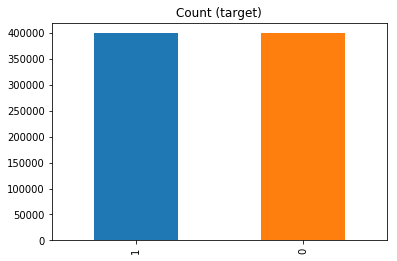

In [56]:
#extract the observations with class zero, equal to the number of obervations equal
df_class_1_under = df_class_1.sample(count_class_0)

#create a new dataframe with the same number of values for our two classes
df_resampled = pd.concat([df_class_1_under, df_class_0], axis=0, ignore_index=True)

print('Random under-sampling:')
print(df_resampled.on_time.value_counts())

df_resampled.on_time.value_counts().plot(kind='bar', title='Count (target)')

In [57]:
#shuffling the data to make it completely random, after resampling
from sklearn.utils import shuffle 
df_resampled = shuffle(df_resampled)

#resetting index
df_resampled = df_resampled.reset_index(drop=True)

In [58]:
df_resampled.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,Scheduled_HourOfDay,delay_second,delay_minute,delay_days,source,destination,dist,Vehicle_location2,VehicleToDestination,on_time
0,6/5/2017 6:40,0,Bx31,TREMONT AV/LANE AV,40.840866,-73.842453,WOODLAWN KATONAH AV,40.902779,-73.868317,NYCT_7744,...,6,67,1.116667,0,"(40.840866, -73.842453)","(40.902778999999995, -73.868317)",7.212940,"(40.882358, -73.84477700000001)",3.012997,1
1,6/2/2017 10:16,0,M15-SBS,SOUTH FERRY/TERMINAL,40.702171,-74.013535,SELECT BUS SERVICE 125ST via 1 AV,40.803150,-73.932266,NYCT_1245,...,10,251,4.183333,0,"(40.702171, -74.013535)","(40.80315, -73.932266)",13.147141,"(40.704322, -74.008629)",12.729131,1
2,6/1/2017 19:04,1,M3,FT GEORGE AV/66 FORT GEORGE AV,40.858330,-73.925385,EAST VILLAGE 8 ST via 5 AV,40.730038,-73.991310,NYCT_6638,...,18,1320,22.000000,0,"(40.85833, -73.92538499999999)","(40.730038, -73.99131)",15.294704,"(40.753933, -73.980558)",2.804613,0
3,6/1/2017 2:13,0,S46,WEST SHORE PLAZA/CHELSEA ST,40.602039,-74.190697,ST GEORGE FERRY via CASTLTN,40.643585,-74.072609,NYCT_8245,...,2,120,2.000000,0,"(40.602039000000005, -74.190697)","(40.643584999999995, -74.072609)",11.005471,"(40.637747, -74.07628199999999)",0.718900,1
4,6/2/2017 16:56,1,Bx3,W 238 ST/BROADWAY,40.884968,-73.900475,WASHINGTON HTS GW BRIDGE,40.849010,-73.936890,NYCT_4396,...,16,186,3.100000,0,"(40.884968, -73.900475)","(40.84901, -73.93689)",5.036865,"(40.849771000000004, -73.916443)",1.726292,1


In [59]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798404 entries, 0 to 798403
Data columns (total 32 columns):
RecordedAtTime               798404 non-null object
DirectionRef                 798404 non-null int64
PublishedLineName            798404 non-null object
OriginName                   798404 non-null object
OriginLat                    798404 non-null float64
OriginLong                   798404 non-null float64
DestinationName              798404 non-null object
DestinationLat               798404 non-null float64
DestinationLong              798404 non-null float64
VehicleRef                   798404 non-null object
VehicleLocation.Latitude     798404 non-null float64
VehicleLocation.Longitude    798404 non-null float64
NextStopPointName            798404 non-null object
ArrivalProximityText         798404 non-null object
DistanceFromStop             798404 non-null object
ExpectedArrivalTime          798404 non-null object
ScheduledArrivalTime         798404 non-null object


In [60]:
#creating two subsets of the dataframe to explore the data according to the different values of our binary output variable.
df_NotOntime = df_resampled[df_resampled['on_time'] == 0]
df_Ontime = df_resampled[df_resampled['on_time'] == 1]


In [125]:
#getting the total number of unique bus line names in the PublishedLineName column
df_resampled.PublishedLineName.describe()

count     798404
unique       305
top           B6
freq       14315
Name: PublishedLineName, dtype: object

In [117]:
#Using the subset of the data for the buses that did not make it on time, and getting the total number of unique bus line
#names in this subset of the data.
df_NotOntime.PublishedLineName.describe()

count     399202
unique       305
top          B41
freq        7546
Name: PublishedLineName, dtype: object

In [118]:
#Using the subset of the data for the buses that did make it on time, and getting the total number of unique bus line 
#names in this subset of the data
df_Ontime.PublishedLineName.describe()

count     399202
unique       236
top           B6
freq        8562
Name: PublishedLineName, dtype: object

There are 69 Bus lines that never made it on time to their destination.

In [120]:
df_resampled.groupby('on_time').PublishedLineName.value_counts()

on_time  PublishedLineName
0        B41                  7546
         B35                  7485
         Q58                  6954
         M101                 6371
         Bx36                 6210
         B15                  6066
         Q44-SBS              5789
         Bx15                 5764
         B6                   5753
         M15-SBS              5733
         B46                  5367
         B82                  5340
         M60-SBS              5124
         M4                   4943
         M7                   4750
         M3                   4687
         B38                  4537
         Bx12-SBS             4408
         M15                  4273
         Bx6                  4247
         M1                   3990
         B44                  3870
         Q32                  3861
         M2                   3797
         Q54                  3789
         Q27                  3775
         Q17                  3529
         X1                 

Text(0.5, 0, 'Latitude')

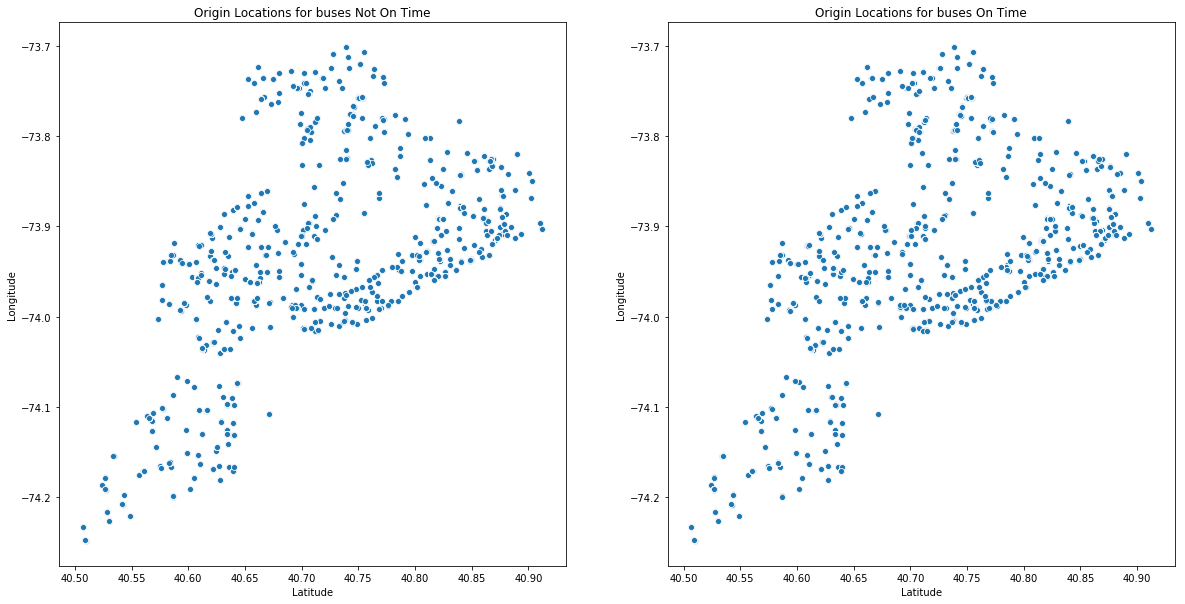

In [66]:
#making two scatter plots to show the Origin locations of buses on time, and not on time, using Origin latitude 
#and Origin longitude

#setting figure size
f = plt.figure(figsize=(20,10))

#making a plot figure that will have one row with two plots in each row
f.add_subplot(1, 2, 1)
sns.scatterplot(x=df_NotOntime.OriginLat, y=df_NotOntime.OriginLong)
plt.title("Origin Locations for buses Not On Time")
plt.ylabel('Longitude')
plt.xlabel('Latitude')

f.add_subplot(1, 2, 2)
sns.scatterplot(x=df_Ontime.OriginLat, y=df_Ontime.OriginLong)
plt.title('Origin Locations for buses On Time')
plt.ylabel('Longitude')
plt.xlabel('Latitude')


Text(0.5, 0, 'Latitude')

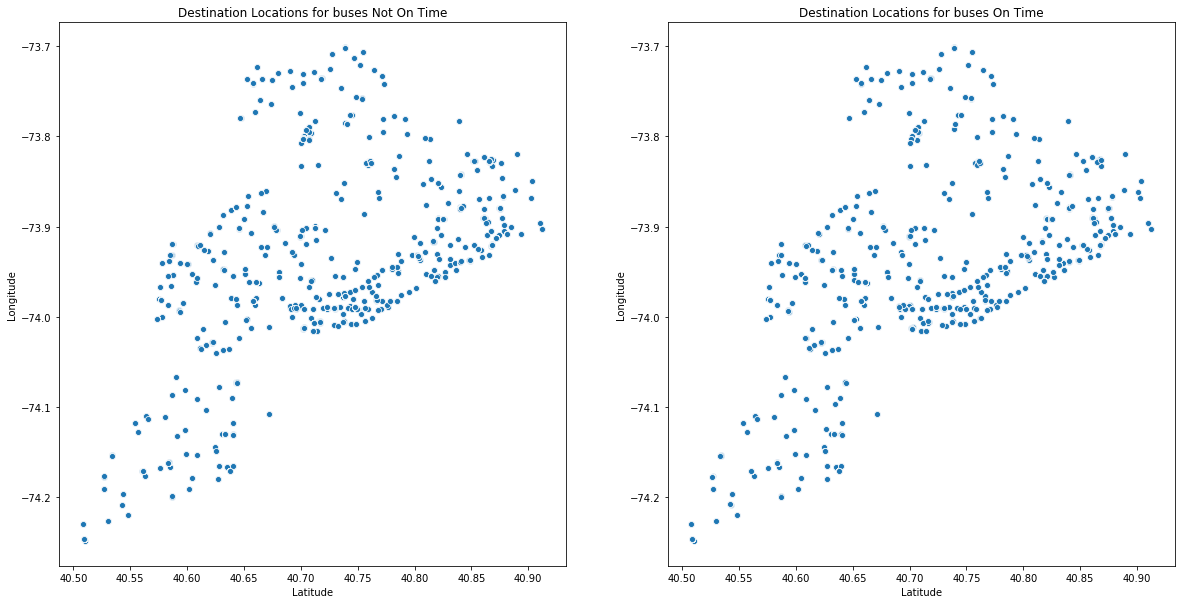

In [67]:
#making two scatter plots to show the Destination locations of buses on time, and not on time, using Destination latitude 
#and Destination longitude

#setting figure size
f = plt.figure(figsize=(20,10))

#making a plot figure that will have one row with two plots in each row
f.add_subplot(1, 2, 1)
sns.scatterplot(x=df_NotOntime.DestinationLat, y=df_NotOntime.DestinationLong)
plt.title("Destination Locations for buses Not On Time")
plt.ylabel('Longitude')
plt.xlabel('Latitude')

f.add_subplot(1, 2, 2)
sns.scatterplot(x=df_Ontime.DestinationLat, y=df_Ontime.DestinationLong)
plt.title('Destination Locations for buses On Time')
plt.ylabel('Longitude')
plt.xlabel('Latitude')

#hue=df_NotOntime.PublishedLineName[:15]

The two sets of scatterplot show the origin locations and destination locations using latitude and longitude for all buses, on time and those not on time, from the dataset.  As you can see, they are near identical for both scenarios, meaning that both scenarios have many common locations between them, and that location in and of itself is not the sole reason for a bus to be on time or not on time.

The box plots below show, show the scheduled hours of arrival for each bus stop.  On the left we have "Scheduled Hours of the day for buses Not On Time", and on the right we have "Scheduled Hours of the day for buses On Time".  As we can see, the median hour for the buses not on time is about 15, which is closer to the late afternoon rush hours.  But the median hour for the buses on time is closer to twelve, which is not close to either the morning or late afternoon rush hours.  

Also something important to note is that for those buses that are not on time, the first quartile (25% of the instances) is at about hour number eleven, which is significantly higher than the first quartile for those buses that were on time, which is at hour number eight.  This may suggest that for those buses that were not on time, the average hour is higher and closer to the later hours in the afternoon when there is probably more traffic on the road versus the average hour for those buses that were on time.

This insight may provide support for the idea that traffic is the differentiating factor on whether or not a bus is on time.

Text(0.5, 1.0, 'Scheduled Hours of the day for buses On Time')

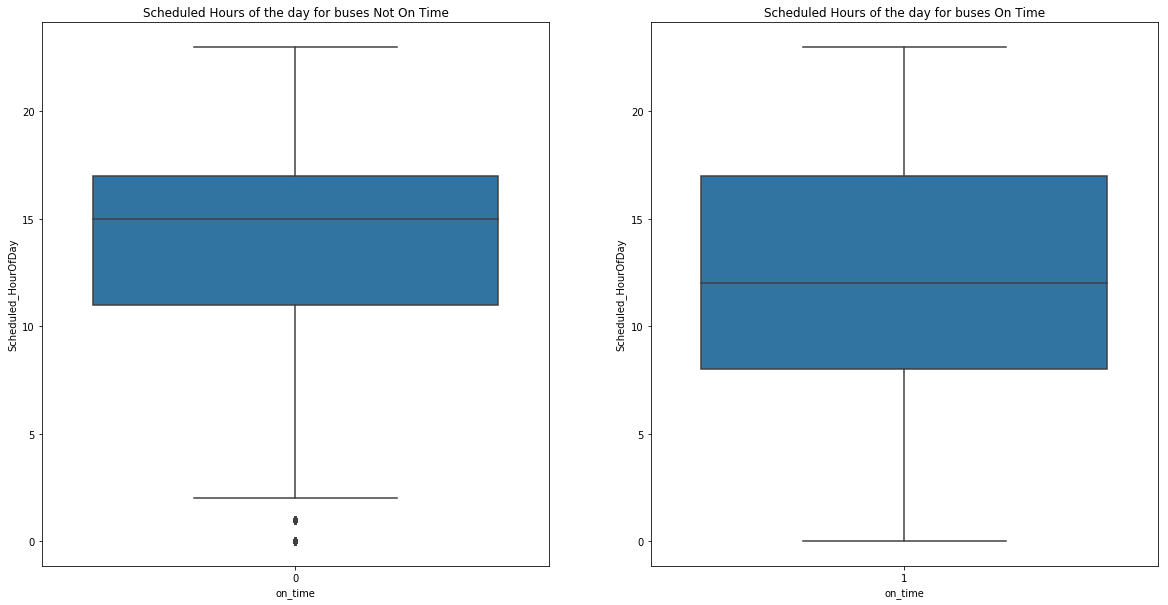

In [68]:
#Making a boxplot for the Scheduled_HourOfDay column for both subsets of our data, df_Ontime and df_NotOntime.

#setting figure size
f = plt.figure(figsize=(20,10))

#making a plot figure that will have one row with two plots in each row
f.add_subplot(1, 2, 1)
sns.boxplot(x=df_NotOntime.on_time, y=df_NotOntime.Scheduled_HourOfDay, data=df_NotOntime)
plt.title("Scheduled Hours of the day for buses Not On Time")


f.add_subplot(1, 2, 2)
sns.boxplot(x=df_Ontime.on_time, y=df_Ontime.Scheduled_HourOfDay, data=df_Ontime)
plt.title("Scheduled Hours of the day for buses On Time")


In [70]:
print(np.mean(df_NotOntime['Scheduled_HourOfDay']))

13.943547377017149


In [71]:
print(np.mean(df_Ontime['Scheduled_HourOfDay']))

12.257886984534146


As expected, the average of the scheduled arrival hour for the buses not on time is higher, at 13.94, versus the average of the scheduled arrival hour for the buses that were on time, which is 12.26

In [72]:
df_resampled.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude',
       'VehicleLocation.Longitude', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime', 'Unnamed: 17', 'expected_date',
       'Scheduled_datetime', 'Expected_datetime', 'delay',
       'Scheduled_HourOfDay', 'delay_second', 'delay_minute', 'delay_days',
       'source', 'destination', 'dist', 'Vehicle_location2',
       'VehicleToDestination', 'on_time'],
      dtype='object')

In [73]:
#dropping some columns and splitting the data and creating the initial train and test splits.
df_X = df_resampled.drop(['RecordedAtTime', 'ArrivalProximityText', 'Unnamed: 17', 'PublishedLineName', 'VehicleRef', 
                 'NextStopPointName', 'ExpectedArrivalTime', 'ScheduledArrivalTime', 'on_time', 'OriginName', 
                 'DestinationName','source', 'destination', 'Vehicle_location2', 'DistanceFromStop', 'Scheduled_datetime', 
                 'Expected_datetime', 'delay', 'delay_second', 'delay_minute', 'delay_days', 'source', 
                 'destination', 'expected_date'], 1)

#getting dummy values for categorical data, and creating dataframe of the independent (predictor) values
#XD_df = pd.get_dummies(X, columns=['OriginName', 'DestinationName'])


Y = df_resampled['on_time']



In [74]:
#examining the dataframe with the predictor variables
df_X.head()

,DirectionRef,OriginLat,OriginLong,DestinationLat,DestinationLong,VehicleLocation.Latitude,VehicleLocation.Longitude,Scheduled_HourOfDay,dist,VehicleToDestination
0,0,40.840866,-73.842453,40.902779,-73.868317,40.882358,-73.844777,6,7.212940,3.012997
1,0,40.702171,-74.013535,40.803150,-73.932266,40.704322,-74.008629,10,13.147141,12.729131
2,1,40.858330,-73.925385,40.730038,-73.991310,40.753933,-73.980558,18,15.294704,2.804613
3,0,40.602039,-74.190697,40.643585,-74.072609,40.637747,-74.076282,2,11.005471,0.718900
4,1,40.884968,-73.900475,40.849010,-73.936890,40.849771,-73.916443,16,5.036865,1.726292


In [75]:
#checking shape of X
df_X.shape

(798404, 10)

In [76]:
#checking which column has NaN value
df_X.isnull().sum().sum()

0

In [77]:
#checking the shape of outcome variable Y.
Y.shape

(798404,)

In [78]:
#creating initial train_test_split, before PCA
train_X, test_X, train_Y, test_Y = train_test_split(df_X, Y, test_size=.25)
print(test_X.shape)
print(test_Y.shape)

#checking for any NaN values in our data.
#print(np.isnan(train_Y).any())
#print(np.isnan(train_X).any().sum())
#print(np.isnan(test_Y).any())
#print(np.isnan(test_X).any().sum())

(199601, 10)
(199601,)


In [79]:
# Create the first model by Initializing and training the decision tree
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=10,
    max_depth=10,
    min_samples_split=10
)

#set start time
start_time_tree = datetime.datetime.now()

#train our tree
decision_tree.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_dtree = decision_tree.predict(test_X)

#get accuracy score from our model
print('Accuracy score for decision tree Model: ' + str(metrics.accuracy_score(test_Y, y_pred_dtree)))

#calculate end time
end_time_tree = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_tree - start_time_tree))
print()

#get accuracy score of decision tree
tree_score = cross_val_score(decision_tree, df_X, Y, cv=10, scoring='accuracy')
print(tree_score)
print('Average cross validated score from our decision tree model is: ' + str(np.mean(tree_score)))

Accuracy score for decision tree Model: 0.6517151717676765

Duration: 0:00:03.582391

[0.65142406 0.65203777 0.65405812 0.64981212 0.65157816 0.64933617
 0.65339429 0.65336924 0.65142786 0.64971192]
Average cross validated score from our decision tree model is: 0.6516149712879831


# Logistic Regression

In [80]:
#initialize and train our model
LogReg = LogisticRegression(C=1e9, random_state=12)

#set start time
start_time4 = datetime.datetime.now()

#fit and train the model
LogReg.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_LogReg = LogReg.predict(test_X)

#get accuracy score from our model
print('Accuracy score for Logistic regression Model: ' + str(metrics.accuracy_score(test_Y, y_pred_LogReg)))

#calculate end time
end_time4 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time4 - start_time4))
print()

#get average accuracy score using cross validation
LogReg_cvs = cross_val_score(LogReg, df_X, Y, cv=10, scoring='accuracy')
print(LogReg_cvs)

print('Average cross validated score from our log regression model is: ' + str(np.mean(LogReg_cvs)))

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy score for Logistic regression Model: 0.6145109493439411

Duration: 0:00:17.593938



C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linea

[0.61319857 0.61170812 0.61470441 0.61337675 0.61093437 0.61206162
 0.61108467 0.61161072 0.61531814 0.60940631]
Average cross validated score from our log regression model is: 0.6123403684702137


# PCA

In [81]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# o

X_scaled = StandardScaler().fit_transform(df_X)

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [82]:
#Apply PCA

pca = PCA(.95)
df_X_pca = pca.fit_transform(X_scaled)

comp_no = pca.n_components_
comp_var_ratio = pca.explained_variance_ratio_

print(comp_no)
print(comp_var_ratio)
#print(p_components)

7
[0.39469367 0.14998777 0.13275981 0.1299811  0.0997486  0.04255881
 0.02226347]


In [83]:
#pca data to dataframe
pca_df = pd.DataFrame(data=df_X_pca)
print(pca_df.head())
print(pca_df.shape)

          0         1         2         3         4         5         6
0 -3.115439  0.834798 -1.014553  0.439529  1.357570  0.142962 -0.558017
1  1.128728  1.225426 -0.988465  1.725572  0.552224 -0.732007 -0.130463
2  0.032555  1.471604  1.236777 -0.471148 -0.806150  1.147802  0.295875
3  3.540825  0.096092 -2.204431 -0.995445  1.994740  0.677572  0.484262
4 -2.218849  1.448646  0.484104 -1.342245 -0.381099 -0.087619  0.096974
(798404, 7)


In [85]:
#subset dataframe X to include only the first 600,000 rows.
df_X_SmallSet = pca_df.iloc[:200000, :]
print(df_X_SmallSet.shape)

#getting a smaller sample set for output variable Y 
Y_SmallSet = Y[:200000]
print(Y_SmallSet.shape)

(200000, 7)
(200000,)


In [86]:
#checking the values in Y
set(Y_SmallSet)

{0, 1}

In [95]:
#creating a train test split based on PCA and full data set.
train_X_PCA, test_X_PCA, train_Y_PCA, test_Y_PCA = train_test_split(pca_df, Y, test_size=.25)
print(test_X_PCA.shape)
print(test_Y_PCA.shape)

(199601, 7)
(199601,)


In [87]:
#creating a second train test split based on PCA and small data set.
train_X_SmallPCA, test_X_SmallPCA, train_Y_SmallPCA, test_Y_SmallPCA = train_test_split(df_X_SmallSet, Y_SmallSet, test_size=.25)
print(test_X_SmallPCA.shape)
print(test_Y_SmallPCA.shape)

(50000, 7)
(50000,)


# Random Forest

In [88]:
# perform grid search to find the optimal parameters for our random forest model, after applying PCA
rforest = ensemble.RandomForestClassifier(random_state=20)
forest_param_grid = {'n_estimators':[100], 'max_depth':[4,6], 'min_samples_split':[6,8,10], 
                     'max_features':[2,4,6], 'criterion':['entropy', 'gini']}
rforest_grid = GridSearchCV(rforest, forest_param_grid, cv=10, verbose=3)
rforest_grid.fit(train_X_SmallPCA, train_Y_SmallPCA)
print('Best parameters for decision tree:', rforest_grid.best_params_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6311579228051464, total=  12.7s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s


[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.625491633891074, total=  12.7s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.1s remaining:    0.0s


[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6290247316845544, total=  12.6s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6285333333333334, total=  12.6s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.633, total=  13.0s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6265333333333334, total=  12.6s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6288, total=

[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=6, n_estimators=100, score=0.6199746649776652, total=  23.5s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.6268915405639625, total=  23.4s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.6245583627758149, total=  23.4s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.625624958336111, total=  23.3s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.

[CV]  criterion=entropy, max_depth=4, max_features=6, min_samples_split=8, n_estimators=100, score=0.618, total=  34.0s
[CV] criterion=entropy, max_depth=4, max_features=6, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=6, min_samples_split=8, n_estimators=100, score=0.6201746783118874, total=  34.2s
[CV] criterion=entropy, max_depth=4, max_features=6, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=6, min_samples_split=8, n_estimators=100, score=0.6236415761050736, total=  34.0s
[CV] criterion=entropy, max_depth=4, max_features=6, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=6, min_samples_split=8, n_estimators=100, score=0.6194412960864057, total=  34.1s
[CV] criterion=entropy, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100, score=0.6252916472

[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, score=0.6384, total=  17.9s
[CV] criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, score=0.6424666666666666, total=  17.9s
[CV] criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, score=0.637, total=  17.9s
[CV] criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, score=0.6449333333333334, total=  17.8s
[CV] criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, score=0.636775785052336

[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100, score=0.6344243717085528, total=  49.1s
[CV] criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100, score=0.6328244783681088, total=  49.5s
[CV] criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100, score=0.6339577361509233, total=  49.0s
[CV] criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100, score=0.6360666666666667, total=  49.1s
[CV] criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100, score=0

[CV]  criterion=gini, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6266417761184079, total=   8.9s
[CV] criterion=gini, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6315754383625575, total=   9.0s
[CV] criterion=gini, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6280418694579639, total=   9.0s
[CV] criterion=gini, max_depth=4, max_features=2, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=2, min_samples_split=8, n_estimators=100, score=0.6323578428104794, total=   9.0s
[CV] criterion=gini, max_depth=4, max_features=2, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=2, min_samples_split=8, n_estimators=100, score=0.627491500566629, total=   

[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.621, total=  16.0s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.6204, total=  16.0s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.621041402760184, total=  16.0s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.6261750783385559, total=  16.0s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.6199079938662577, total=  16.0s
[CV] criterion=gini,

[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100, score=0.6256666666666667, total=  23.0s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100, score=0.6316, total=  23.1s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100, score=0.6183333333333333, total=  22.9s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100, score=0.6184, total=  23.0s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100, score=0.6207080472031469, total=  22.9s
[CV] crit

[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100, score=0.6315578961402574, total=  22.5s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100, score=0.6336910872608493, total=  22.4s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100, score=0.6376, total=  22.4s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100, score=0.6416666666666667, total=  22.3s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100, score=0.6338666666666667, total=  22.4s
[CV] c

[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100, score=0.6275085005667045, total=  32.4s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100, score=0.6339577361509233, total=  32.5s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100, score=0.6327578161455903, total=  32.3s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100, score=0.6345576961535898, total=  32.5s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100, score=0.6368, total=  32.5s
[CV] c

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 149.0min finished


Best parameters for decision tree: {'criterion': 'gini', 'max_depth': 6, 'max_features': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [89]:
print('Best score for Random Forest:', rforest_grid.best_score_)

Best score for Random Forest: 0.64082


In [ ]:
#initialize and train our random forest model with PCA
rand_forest_pca = ensemble.RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=16, max_features=4,
                                              min_samples_split=10)

#set start time
start_time_rforest = datetime.datetime.now()

rand_forest_pca.fit(train_X_PCA, train_Y_PCA)

# Classify, storing the result in a new variable.
y_pred_rforest_pca = rand_forest_pca.predict(test_X_PCA)

#get accuracy score from our model
print('Accuracy score for Random Forest Model: ' + str(metrics.accuracy_score(test_Y_PCA, y_pred_rforest_pca)))

#calculate end time
end_time_rforest = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_rforest - start_time_rforest))
print()

#get average accuracy score of our random forest through cross validation
rforest_pca_cvs = cross_val_score(rand_forest_pca, pca_df, Y, cv=10, scoring='accuracy')
print(rforest_pca_cvs)
print('Average cross validated score from our Random Forest Model is: ' + str(np.mean(rforest_pca_cvs)))

Accuracy score for Random Forest Model: 0.6776318755918056

Duration: 0:09:03.389027



In [104]:
# create confusion matrix for random forest and PCA
print("Confusion Matrix: \n", confusion_matrix(test_Y_PCA, y_pred_rforest_pca))
print()

# perform classification report of the logistic regression model
class_names = ['Class_0', 'Class_1']
rforest_report = classification_report(test_Y_PCA, y_pred_rforest_pca, target_names=class_names)
print(rforest_report)

Confusion Matrix: 
 [[66721 33088]
 [34679 65113]]

              precision    recall  f1-score   support

     Class_0       0.66      0.67      0.66     99809
     Class_1       0.66      0.65      0.66     99792

   micro avg       0.66      0.66      0.66    199601
   macro avg       0.66      0.66      0.66    199601
weighted avg       0.66      0.66      0.66    199601



AUC Score: 0.718


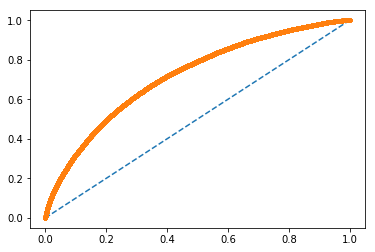

In [106]:
#Get AUC and create ROC
# predict probabilities
probs_rforest_pca = rand_forest_pca.predict_proba(test_X_PCA)
# keep probabilities for the positive outcome only
probs_rforest_pca = probs_rforest_pca[:, 1]
# calculate AUC
rforest_auc = roc_auc_score(test_Y_PCA, probs_rforest_pca)
print('AUC Score: %.3f' % rforest_auc)
# calculate roc curve
fpr_rforest_pca, tpr_rforest_pca, thresholds_rforest_pca = roc_curve(test_Y_PCA, probs_rforest_pca)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_rforest_pca, tpr_rforest_pca, marker='.')
# show the plot
plt.show()

# Logistic Regression

In [107]:
#initialize and train our model after PCA
LogReg_pca = LogisticRegression(C=1e9, random_state=12)

#set start time
start_time4 = datetime.datetime.now()

#fit and train the model
LogReg_pca.fit(train_X_PCA, train_Y_PCA)

# Classify, storing the result in a new variable.
y_pred_LogReg_pca = LogReg_pca.predict(test_X_PCA)

#get accuracy score from our model
print('Accuracy score for Logistic regression Model after pca: ' + str(metrics.accuracy_score(test_Y_PCA, y_pred_LogReg_pca)))

#calculate end time
end_time4 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time4 - start_time4))
print()

#get average accuracy score using cross validation
LogReg_cvs_pca = cross_val_score(LogReg_pca, pca_df, Y, cv=10, scoring='accuracy')
print(LogReg_cvs_pca)

print('Average cross validated score from our log regression model is: ' + str(np.mean(LogReg_cvs_pca)))

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy score for Logistic regression Model after pca: 0.6100520538474257

Duration: 0:00:01.170857



C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linea

[0.6141254  0.610631   0.61362725 0.61212425 0.60955661 0.60980711
 0.61124749 0.61122244 0.61362725 0.60948146]
Average cross validated score from our log regression model is: 0.611545028165346


AUC Score: 0.653


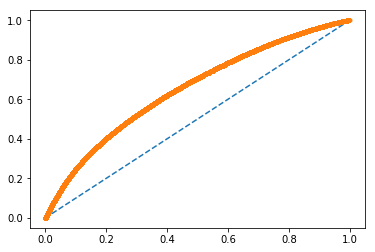


              precision    recall  f1-score   support

     Class_0       0.61      0.60      0.60     99809
     Class_1       0.61      0.62      0.61     99792

   micro avg       0.61      0.61      0.61    199601
   macro avg       0.61      0.61      0.61    199601
weighted avg       0.61      0.61      0.61    199601




array([[59603, 40206],
       [37628, 62164]], dtype=int64)

In [108]:
#Get AUC and create ROC
# predict probabilities
probs_LogReg_pca = LogReg_pca.predict_proba(test_X_PCA)
# keep probabilities for the positive outcome only
probs_LogReg_pca = probs_LogReg_pca[:, 1]
# calculate AUC
LogReg_pca_auc = roc_auc_score(test_Y_PCA, probs_LogReg_pca)
print('AUC Score: %.3f' % LogReg_pca_auc)
# calculate roc curve
fpr_LogReg_pca, tpr_LogReg_pca, thresholds_LogReg_pca = roc_curve(test_Y_PCA, probs_LogReg_pca)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_LogReg_pca, tpr_LogReg_pca, marker='.')
# show the plot
plt.show()
print()

# perform classification report of the logistic regression model
class_names = ['Class_0', 'Class_1']
LogReg_report_pca = classification_report(test_Y_PCA, y_pred_LogReg_pca, target_names=class_names)
print(LogReg_report_pca)
print()

# create confusion matrix
confusion_matrix(test_Y_PCA, y_pred_LogReg_pca)

# KNN

In [109]:
# perform grid search to find the optimal parameters for our KNN model using full data.
KNN_model = KNeighborsClassifier()
KNN_params = {'n_neighbors':[5,10,15], 'weights':['uniform', 'distance']}
KNN_grid = GridSearchCV(KNN_model, KNN_params, cv=5)
KNN_grid.fit(train_X_PCA, train_Y_PCA)
print('Best parameters for data:', KNN_grid.best_params_)

Best parameters for data: {'n_neighbors': 15, 'weights': 'uniform'}


In [124]:
#initialize and train our model using the training set
KNN_pca = KNeighborsClassifier(n_neighbors=15, weights='uniform')

#set start time
starttime_knn = datetime.datetime.now()

#fit and train the model
KNN_pca.fit(train_X_PCA,train_Y_PCA)

#Make predictions using test_X, and store results in new variable
y_pred_KNN_pca = KNN_pca.predict(test_X_PCA)

print('Accuracy score for KNN Model: ' + str(metrics.accuracy_score(test_Y_PCA, y_pred_KNN_pca)))

#calculate end time
endtime_knn = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(endtime_knn - starttime_knn))
print()


KNN_cvs_pca = cross_val_score(KNN_pca, pca_df, Y, cv=5, scoring='accuracy')
print(KNN_cvs_pca)
print('Average cross validated score from our KNN model is: ' + str(np.mean(KNN_cvs_pca)))


Accuracy score for KNN Model: 0.6638744294868262

Duration: 0:00:06.070446

[0.66615523 0.66565424 0.66486097 0.66761022 0.66772921]
Average cross validated score from our KNN model is: 0.666401974425172


AUC Score: 0.723


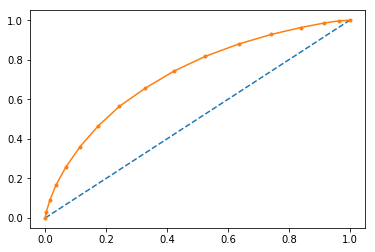

              precision    recall  f1-score   support

     Class_0       0.66      0.67      0.67     99809
     Class_1       0.67      0.66      0.66     99792

   micro avg       0.66      0.66      0.66    199601
   macro avg       0.66      0.66      0.66    199601
weighted avg       0.66      0.66      0.66    199601



array([[66977, 32832],
       [34259, 65533]], dtype=int64)

In [126]:
#Get AUC and create ROC
# predict probabilities
probs_KNN_pca = KNN_pca.predict_proba(test_X_PCA)
# keep probabilities for the positive outcome only
probs_KNN_pca = probs_KNN_pca[:, 1]
# calculate AUC
KNN_pca_auc = roc_auc_score(test_Y_PCA, probs_KNN_pca)
print('AUC Score: %.3f' % KNN_pca_auc)
# calculate roc curve
fpr_KNN_pca, tpr_KNN_pca, thresholds_KNN_pca = roc_curve(test_Y_PCA, probs_KNN_pca)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_KNN_pca, tpr_KNN_pca, marker='.')
# show the plot
plt.show()

# perform classification report of the KNN model
class_names = ['Class_0', 'Class_1']
KNN_report_pca = classification_report(test_Y_PCA, y_pred_KNN_pca, target_names=class_names)
print(KNN_report_pca)

# confusion Matrix
confusion_matrix(test_Y_PCA, y_pred_KNN_pca)


# Gradient Boosting

In [ ]:
#Run gridsearchcv to find the best parameters for gradient boosting using PCA
gboost_param_grid = {'n_estimators':[100,200], 'max_depth':[4,6,8], 'min_samples_leaf': [3, 5, 9], 
                     'learning_rate': [.05, .02, .01], 'subsample': [.7, .8, .9]}
gb_model = ensemble.GradientBoostingClassifier(random_state=67)

gb_grid = GridSearchCV(gb_model, gboost_param_grid, cv=5)
gb_grid.fit(train_X_PCA, train_Y_PCA)
print('Best parameters for Gradient Boost Model are:', gb_grid.best_params_)

In [ ]:
print('Best parameters for Gradient Boost Model are:', gb_grid.best_params_)
print('Best score for Gradient Boost Model are:', gb_grid.best_score_)

In [ ]:
# Initialize and fit the model using PCA
Grad_boost_pca = ensemble.GradientBoostingClassifier(learning_rate=0.02, max_depth=2, min_samples_leaf=5, 
                                                 n_estimators=200, subsample=0.7, random_state=67)

#set start time
start_time_gb = datetime.datetime.now()

#fit and train the model
Grad_boost_pca.fit(train_X_pca, train_Y_pca)

# Classify, storing the result in a new variable.
y_pred_Gboost_pca = Grad_boost.predict(test_X_pca)

#get accuracy score from our model
print('Accuracy score for Gradient Boost Model: ' + str(metrics.accuracy_score(test_Y_pca, y_pred_Gboost_pca)))

#calculate end time
end_time_gb = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_gb - start_time_gb))
print()

#get average accuracy score using cross validation
Grad_boost_cvs_pca = cross_val_score(Grad_boost_pca, X_pca, Y, cv=5, scoring='accuracy')
print(Grad_boost_cvs_pca)

print('Average cross validated score from our Gradient Boosting model is: ' + str(np.mean(Grad_boost_cvs_pca)))

In [ ]:
# perform classification report of the Gradient Boosting model
class_names = ['Class_0', 'Class_1']
Gboost_report = classification_report(test_Y_pca, y_pred_Gboost_pca, target_names=class_names)
print(Gboost_report)
print()
#confusion matrix
print('Confusion Matrix:')
confusion_matrix(test_Y_pca, y_pred_Gboost_pca)
print()

#Get AUC and create ROC
# predict probabilities
probs_Gboost_pca = Grad_boost_pca.predict_proba(test_X_pca)
# keep probabilities for the positive outcome only
probs_Gboost_pca = probs_Gboost_pca[:, 1]
# calculate AUC
Gboost_auc = roc_auc_score(test_Y_pca, probs_Gboost_pca)
print('AUC Score: %.3f' % Gboost_auc)
# calculate roc curve
fpr_Gboost_pca, tpr_Gboost_pca, thresholds_Gboost_pca = roc_curve(test_Y_pca, probs_Gboost_pca)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_Gboost_pca, tpr_Gboost_pca, marker='.')
# show the plot
plt.show()

# SelectKBest

In [ ]:
kbest = SelectKBest(f_classif)
pipeline = Pipeline([('kbest', kbest), ('lr', LogisticRegression())])
grid_search = GridSearchCV(pipeline, {'kbest__k': [1,2,3,4], 'lr__C': np.logspace(-10, 10, 5)})
grid_search.fit(train_X_pca, train_Y_pca)

In [ ]:
#performing GridsearchCV to get the best parameters for SelectKBest.
#Kbest = SelectKBest().fit_transform(X, Y)
#K_params = {'k':[1,2,3,4,5,6], 'score_func':[chi2, f_classif]}
#Kgrid = GridSearchCV(Kbest, K_params, cv=5, scoring='accuracy')
#Kgrid.fit(X, Y)
#print('Best parameters for SelectKBest:', Kgrid.best_params_)

In [ ]:
#applying selectKBest.
X_skb = SelectKBest(f_classif, k=6).fit_transform(X, Y)
print(X_skb.shape)

In [ ]:
#After applying SelectKBest, I split the data into a third set of train and test groups
train_X_skb, test_X_skb, train_Y_skb, test_Y_skb = train_test_split(X_skb, Y, test_size=.3, random_state=20)